# Computer Practical 3: Hyperparameters and Kernels

Building from the last practical, we will extend our implementation of Gaussian processes to *hyperparameters*. 

We require the following libraries (use `install.packages()` if the packages are not available):

In [1]:
library(reshape2)
library(ggplot2)

options(repr.plot.width = 4, repr.plot.height = 3) 


## Tutorial: Gaussian Processes

I have reformated most of the code from last time to be more reusable.

### Reformated Code

#### Mean Functions

In [2]:
#mean functions:

zero_mean = function(x, ...) {
    # zero mean function
    return(numeric(length(x)))
}

constant_mean = function(x, ...) {
    # constant kernel 
    return(numeric(length(x)) + 1)
}

linear_mean = function(x, ...) {
    # linear mean function
    return(x)
}

#### Kernel Code

In [3]:
# kernel functions:

brownian_kernel = function(x, y, ...) {
    # brownian motion kernel
    kern = function(x, y) {
        return(pmin(x, y))
    }
    return(outer(x, y, kern))
}

squared_exponential_kernel = function(x, y, ...) {
    # squared exponential kernel
    kern = function(x, y) {
        return(exp(- (x - y) ** 2))
    }
    return(outer(x, y, kern))
}

exponential_kernel = function(x, y, ...) {
    # exponential kernel
    kern = function(x, y) {
        return(exp(-abs(x - y)))
    }
    return(outer(x, y, kern))
}

matern_32_kernel = function(x, y, ...) {
    # Matern kernel with nu = 3/2
    kern = function(x, y) {
        d = abs(x - y)
        term1 = 1 + sqrt(3) * d
        term2 = exp(-sqrt(3) * d)
        return(term1 * term2)
    }
    return(outer(x, y, kern))
}

matern_52_kernel = function(x, y, ...) {
    # Matern kernel with nu = 5/2
    kern = function(x, y) {
        d = abs(x - y)
        term1 = 1 + sqrt(5) * d + 5 / 3 * d ** 2
        term2 = exp(-sqrt(5) * d)
        return(term1 * term2)
    }
    return(outer(x, y, kern))
}

rational_quadratic_kernel = function(x, y, ...) {
    # rational quadratic kernel
    kern = function(x, y) {
        return((1 + abs(x-y) / 2) ** (-1))
    }
    return(outer(x, y, kern))
}

linear_kernel = function(x, y, ...) {
    # linear kernel
    kern = function(x, y) {
        return(1 + x * y)
    }
    return(outer(x, y, kern))
}

quadratic_kernel = function(x, y, ...) {
    # quadratic kernel
    kern = function(x, y) {
        return(1 + x * y + (x * y) ** 2)
    }
    return(outer(x, y, kern))
}

#### Gaussian Process Code

In [4]:
# Samples from MVN
rmvn_svd = function(N, mean, covariance) {
    # samples from the MVN using singular value decomposition

    n <- length(mean) # dimension of random vector

    standard_normal_sample <- rnorm(n * N)
    standard_mvn_sample <- matrix(standard_normal_sample, nrow = N)

    svd_out <- svd(covariance)
    square_root =  svd_out$v %*% sqrt(diag(svd_out$d))
    output <- square_root %*% t(standard_mvn_sample) + mean

    return(t(output))
}

# Computes the log density of MVN
dmvn = function(x, mean, covariance) {
    # computes log density of MVN
    if (is.vector(x)) {
        x = matrix(x, ncol = length(x))
    }
    n = ncol(x)

    cholesky = chol(covariance)
    solved_cholesky = backsolve(cholesky, t(x) - mean, transpose = TRUE)
    quad_form = colSums(solved_cholesky**2)
    output = -sum(log(diag(cholesky))) - 0.5 * n * log(2 * pi) - 0.5 * quad_form
    names(output) = rownames(x)
    return(output)
}

# Computes conditional mvn
condmvn = function(a, mu1, mu2, K11, K12, K22) {
    # computes conditional of MVN

    inv_K22 = solve(K22)

    tilde_mu = mu1 + K12 %*% inv_K22 %*% (a - mu2)
    tilde_K = K11 - K12 %*% inv_K22 %*% t(K12)

    output = list("mean_vec" = as.vector(tilde_mu), "cov_mat" = tilde_K)

    return(output)
}

# Computes posterior Gaussian Process
gp_posterior = function(x_pred, x_cond, y_cond, mean_func, kernel_func, ...) {
    # Computes the posterior mean vector and posterior covariance matrix
    # at locations x_pred from
    # conditioning GP f = y_cond at locations x_cond

    cov_mat_cond = kernel_func(x_cond, x_cond, ...)
    cov_mat_pred = kernel_func(x_pred, x_pred, ...)
    cross_covariance = kernel_func(x_pred, x_cond, ...)

    mean_cond = mean_func(x_cond, ...)
    mean_pred = mean_func(x_pred, ...)

    condmvn_output = condmvn(y_cond, mean_pred, mean_cond, cov_mat_pred, cross_covariance, cov_mat_cond)
    return(condmvn_output)
}

gp_prior_sample = function(N, x_pred, mean_func, kernel_func, ...) {
    # Samples N times from the prior GP at locations x_pred
    mean_vec = mean_func(x_pred, ...)
    cov_mat = kernel_func(x_pred, x_pred, ...)
    return(rmvn_svd(N, mean_vec, cov_mat))
}

gp_posterior_sample = function(N, x_pred, x_cond, y_cond, mean_func, kernel_func, ...) {
    # Samples N from the posterior GP at locations x_pred
    # Conditioning f = y_cond at locations x_cond
    output = gp_posterior(x_pred, x_cond, y_cond, mean_func, kernel_func, ...)

    return(rmvn_svd(N, output$mean_vec, output$cov_mat))
}

### How to use the code:

The above code can perform the following functionalities:

- Given a mean function $m$ and kernel $k$, sample from the prior Gaussian process $$ f\sim\mathcal{GP}(m,k)$$
- Given a mean function $m$ and kernel $k$, sample from the posterior Gaussian process $$ f\,|\,\underline{f}_{\mathrm{X}} = \underline{a} \sim\mathcal{GP}(\tilde{m},\tilde{k})$$


#### Sampling from the Prior

In [5]:
N = 3 # number of samples
x_pred = seq(-10,10,length.out=200) # X locations to sample

prior_sample = gp_prior_sample(N, x_pred, zero_mean, matern_52_kernel) # gp prior sample

Plotting output:

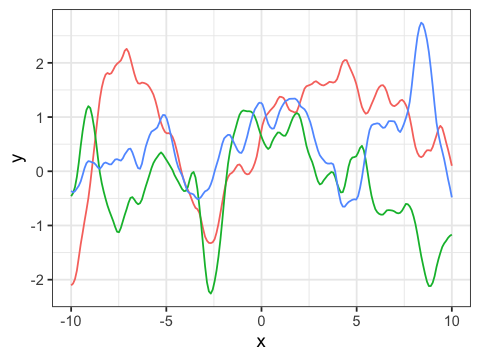

In [6]:
gp_samples_df = melt(data.frame(x_pred, t(prior_sample)), id = "x_pred") # turn into a dataframe

gp_sample_plot = ggplot(gp_samples_df) +
                geom_line(aes(x = x_pred, y = value, group = variable, color=variable), show.legend = FALSE) +
                theme_bw() + labs(x = "x", y = "y") 

gp_sample_plot

#### Sampling from Posterior

In [8]:
N = 200 # number of samples
x_pred = seq(-10,10,length.out=400) # X locations to sample

y_cond = c(-1, 2, 3, -2, 6) # y values we condition upon
x_cond = c(-5, -0.5, 2, 4, 6) # x values we condition upon

posterior_sample = gp_posterior_sample(N, x_pred, x_cond, y_cond, zero_mean, matern_52_kernel) # gp posterior sample

Plotting output:

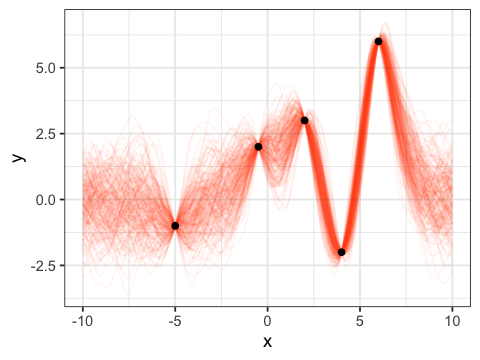

In [9]:
gp_samples_df = melt(data.frame(x_pred, t(posterior_sample)), id = "x_pred") # turn into a dataframe

point_df = data.frame(x = x_cond, y = y_cond)


gp_sample_plot = ggplot(gp_samples_df) +
                geom_line(aes(x = x_pred, y = value, group = variable), color='#ff550c', alpha=0.05, show.legend = FALSE) +
                theme_bw() + labs(x = "x", y = "y") +
                geom_point(data = point_df, aes(x = x, y = y))

gp_sample_plot

#### Visualising with Posterior Mean and Posterior Standard Deviations

In [10]:
posterior_gp = gp_posterior(x_pred, x_cond, y_cond, zero_mean, matern_52_kernel)

posterior_mean_vector = posterior_gp$mean_vec # mean at each x point
posterior_covariance_matrix = posterior_gp$cov_mat

posterior_variance = diag(posterior_covariance_matrix) # variances at each x point
posterior_sd = sqrt(posterior_variance) # standard deviations at each x point

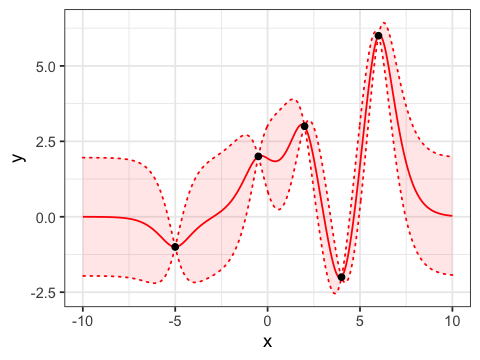

In [11]:
gp_df <- data.frame(x = x_pred, y = posterior_mean_vector,
                    y_max = posterior_mean_vector + 1.96 * posterior_sd,
                    y_min = posterior_mean_vector - 1.96 * posterior_sd)

point_df <- data.frame(x = x_cond, y = y_cond)

gp_posterior_plot <- ggplot(gp_df) +
                geom_line(aes(x = x, y = y), colour = "red") +
                geom_ribbon(aes(x = x, ymin = y_min, ymax = y_max), alpha = 0.1,
                            fill = "red", color = "red", linetype = "dotted") +
                geom_point(data = point_df, aes(x = x, y = y)) + theme_bw()
gp_posterior_plot

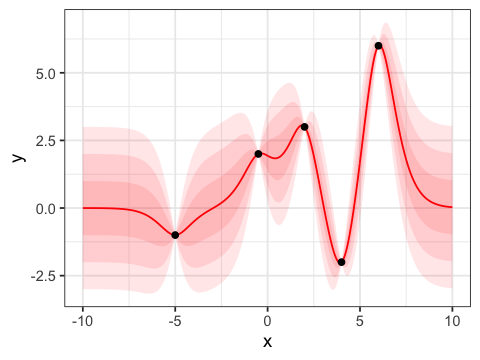

In [12]:
gp_df <- data.frame(x = x_pred, y = posterior_mean_vector,
                    y_max1 = posterior_mean_vector + 1 * posterior_sd,
                    y_min1 = posterior_mean_vector - 1 * posterior_sd,
                    y_max2 = posterior_mean_vector + 2 * posterior_sd,
                    y_min2 = posterior_mean_vector - 2 * posterior_sd,
                    y_max3 = posterior_mean_vector + 3 * posterior_sd,
                    y_min3 = posterior_mean_vector - 3 * posterior_sd)

point_df <- data.frame(x = x_cond, y = y_cond)

gp_posterior_plot <- ggplot(gp_df) +
                geom_line(aes(x = x, y = y), colour = "red") +
                geom_ribbon(aes(x = x, ymin = y_min1, ymax = y_max1), alpha = 0.1,
                            fill = "red", color = "NA") +
                geom_ribbon(aes(x = x, ymin = y_min2, ymax = y_max2), alpha = 0.1,
                fill = "red", color = "NA") +
                geom_ribbon(aes(x = x, ymin = y_min3, ymax = y_max3), alpha = 0.1,
                fill = "red", color = "NA") +
                geom_point(data = point_df, aes(x = x, y = y)) + theme_bw()
gp_posterior_plot

## Task 1: Introducing Hyperparameters

Pick one of the above kernels and or mean functions and introduce their hyperparameters as additional arguments to the function. 

It may be helpful to look at the course notes to see how the hyperparameters are used.

In order for the code to work properly in the subsequent parts, we have to introduce *optional arguments* and *missing arguments*.

#### Optional Arguments

Optional arguments in an `R` function is specified by the use of `...` after the arguments. For instance, in the following function, we introduce optional arguments.

In [90]:
func = function(x, ...) {
    return(x)
}

print(func(3))
print(func(3,1,2,3,31,2,3,1,3,4))

[1] 3
[1] 3


#### Missing Arguments

Using the function `missing` can check whether an argument in an `R` function has been supplied or not.

If an argument has been provided, then we will use that value. If no argument has been provided, then we should supply a default value. 

This is one approach of specifying default argument values in `R` or by changing the behaviour of a function depending on whether some argument has been provided or not.

For example, the following function checks whether `y` has been provided. If it has not, then it will default to `y=1`. If it has been provided, then we will use that value:

In [101]:
func2 = function(x, y) {
    if (missing(y)){
        y = 1
    }
    return(x + y)
}

print(func2(3)) # expect to return 3+1 = 4, since no y value provided
print(func2(3,2)) # expect to return 5, since a y value has been provided

[1] 4
[1] 5


#### Example

For example, the Matern kernel has the amplitude parameter $\lambda^2$ and lengthscale parameter $\ell$. 

In the following code, the amplitude is denoted as `amplitude` and the lengthscale is denoted as `lengthscale`. 

- The Matern kernel function has the optional arguments specified by `...`.
- Default values of `amplitude` and `lengthscale` are provided if no value is provided in the argument. These are `1` and `1` for the `amplitude` and `lengthscale` respectively.

In [13]:
matern_52_kernel = function(x, y, amplitude, lengthscale, ...) {
    # Matern kernel with nu = 5/2
    if (missing(amplitude)) {
        amplitude = 1
    }
    if (missing(lengthscale)) {
        lengthscale = 1
    }
    kern = function(x, y) {
        d = abs(x - y) / lengthscale
        term1 = 1 + sqrt(5) * d + 5 / 3 * d ** 2
        term2 = exp(-sqrt(5) * d)
        return(amplitude ** 2 * term1 * term2)
    }
    return(outer(x, y, kern))
}

In order to check your code is working. Try changing the values of the hyperparameters and plot samples from the prior and posterior. 

If working correctly, the samples should look noticeably different as you change the hyperparameter values.

In order to supply hyperparameter values with our code we should specify them in the optional arguments:

In [185]:
N = 3 # number of samples
x_pred = seq(-10,10,length.out=200) # X locations to sample

# set amplitude = 2 and lengthscale = 0.1
prior_sample = gp_prior_sample(N, x_pred, zero_mean, matern_52_kernel_new, 
                amplitude = 2, lengthscale = 0.1) 

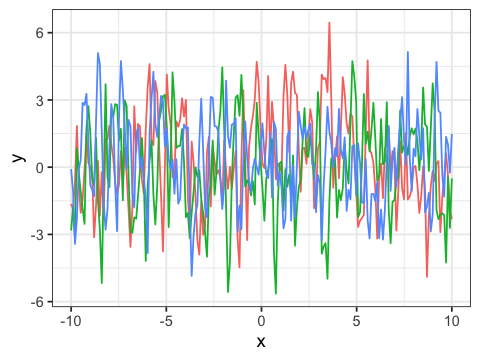

In [186]:
gp_samples_df = melt(data.frame(x_pred, t(prior_sample)), id = "x_pred") # turn into a dataframe

gp_sample_plot = ggplot(gp_samples_df) +
                geom_line(aes(x = x_pred, y = value, group = variable, color=variable), show.legend = FALSE) +
                theme_bw() + labs(x = "x", y = "y") 

gp_sample_plot

In [187]:
N = 3 # number of samples
x_pred = seq(-10,10,length.out=200) # X locations to sample

# set amplitude = 2 and lengthscale = 0.1
prior_sample = gp_prior_sample(N, x_pred, zero_mean, matern_52_kernel, 
                amplitude = 2, lengthscale = 0.1) 

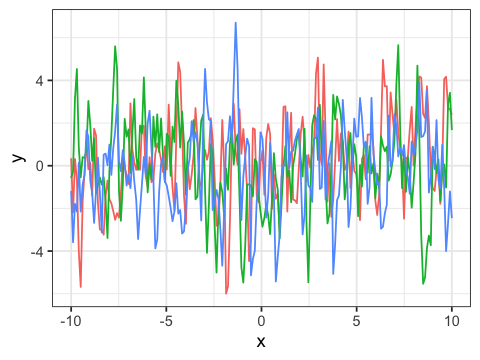

In [188]:
gp_samples_df = melt(data.frame(x_pred, t(prior_sample)), id = "x_pred") # turn into a dataframe

gp_sample_plot = ggplot(gp_samples_df) +
                geom_line(aes(x = x_pred, y = value, group = variable, color=variable), show.legend = FALSE) +
                theme_bw() + labs(x = "x", y = "y") 

gp_sample_plot

In [105]:
N = 3 # number of samples
x_pred = seq(-10,10,length.out=200) # X locations to sample

# set amplitude = 0.1 and lengthscale = 10
prior_sample = gp_prior_sample(N, x_pred, zero_mean, matern_52_kernel, 
                amplitude = 0.1, lengthscale = 10) 

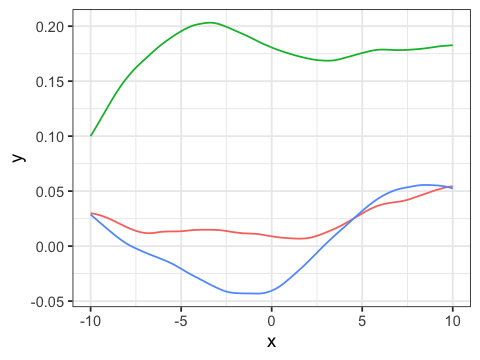

In [106]:
gp_samples_df = melt(data.frame(x_pred, t(prior_sample)), id = "x_pred") # turn into a dataframe

gp_sample_plot = ggplot(gp_samples_df) +
                geom_line(aes(x = x_pred, y = value, group = variable, color=variable), show.legend = FALSE) +
                theme_bw() + labs(x = "x", y = "y") 

gp_sample_plot

## Task 2: The Likelihood Function

Your next task is to implement the log-likelihood function.

Suppose we observe that $f(x_1) = y_1, \ldots, f(x_n) = y_n$. We would like to compute the probability of observing $y_1,\ldots,y_n$ for given hyperparameter values.

Let $\underline{\theta}$ denote the vector of hyperparameters. Derive the likelihood function $L$ for the observations $f(x_1) = y_1, \ldots, f(x_n) = y_n$, where $f \sim \mathcal{GP}(m,k)$:

$$ L(\underline{\theta}; \underline{y}) = ...$$

(*Note: I would like the general form of the log-likelihood for any mean or kernel, not for your particular kernel*)

After you have done this, implement this as an `R` function:

In [14]:
gp_log_likelihood = function(x_cond, y_cond, mean_func, kernel_func, ...) {
    mean_vector = mean_func(x_cond, ...)
    cov_mat = kernel_func(x_cond, x_cond, ...)
    log_likelihood = dmvn(y_cond, mean_vector, cov_mat)
    return(log_likelihood)
}

The intention of the above function is that the values of the *hyperparameters* will be provided in the optional argument `...`


The following function from practical 1 will be useful:

In [15]:
# Computes the log density of MVN
dmvn = function(x, mean, covariance) {
    if (is.vector(x)) {
        x = matrix(x, ncol = length(x))
    }
    n = ncol(x)

    cholesky = chol(covariance)
    solved_cholesky = backsolve(cholesky, t(x) - mean, transpose = TRUE)
    quad_form = colSums(solved_cholesky**2)
    output = -sum(log(diag(cholesky))) - 0.5 * n * log(2 * pi) - 0.5 * quad_form
    names(output) = rownames(x)
    return(output)
}

If your code is working, try to change specify hyperparameter values and see if the log-likelihood changes.

For example:

In [18]:
x_cond

[1] -5.0 -0.5  2.0  4.0  6.0

In [19]:
y_cond

[1] -1  2  3 -2  6

In [16]:
# log-likelihood with amplitude = 1 and lengthscale = 2
gp_log_likelihood(x_cond, y_cond, zero_mean, matern_52_kernel, amplitude=1, lengthscale=2)

[1] -61.55422

In [109]:
# log-likelihood with amplitude = 2 and lengthscale = 2
gp_log_likelihood(x_cond, y_cond, zero_mean, matern_52_kernel, amplitude=2, lengthscale=2)
# this has a larger value and therefore is a better hyperparameter choice

[1] -21.97205

Note that these above values will be different depending on the kernel you are using.

## Task 3: Maximum Likelihood Estimation

The final task is to try to perform maximum likelihood estimation through a grid search.

We will only try to optimise one hyperparameter this way. Therefore, fix one hyperparameter such as the `amplitude` and try to maximise the other.

This can be achieved in the following steps:

1. Define a grid of hyperparameter values that you will evaluate the log-likelihood at.
2. Evaluate the log-likelihood for each member of this grid. Here, I would use a for-loop.
3. Plot the resulting log-likelihood surface.

In order to perform MLE, we also need data to try and infer the hyperparameter values. For this, I will define a function and use evaluations of this function at some $x$ locations to infer the hyperparameters.

Feel free to use any pair of `x_cond` and `y_cond` you would like in this part.

#### Function Definition

In [175]:
my_func = function(x) {
    return(exp(sin(4 * x) * x / 20))
}

x_cond = seq(-10, 10, length.out = 37)
y_cond =  my_func(x_cond)

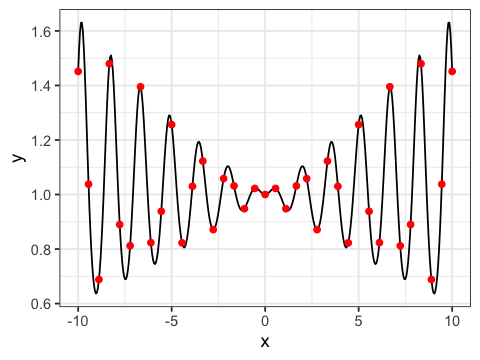

In [176]:
x = seq(-10, 10, length.out = 400)
y = my_func(x)

my_func_df = data.frame(x = x, y = y)
point_df <- data.frame(x = x_cond, y = y_cond)

ggplot(my_func_df) +
    geom_line(aes(x = x, y = y)) +
    geom_point(data = point_df, aes(x = x, y = y), color='red') + 
    theme_bw() + labs(x = "x", y = "y") 

#### Example

In the following code I am performing MLE of the lengthscale parameter. I will fix the `amplitude` to be `1`.

In [177]:
n_grid = 200 # number of elements in lengthscale_grid
lengthscale_grid = seq(0.001, 2, length.out = n_grid) # the vector of lengthscales used in the log-likelihood evalutions

log_lik_evals = numeric(n_grid) # vector to record the log-likelihood evaluations

for (i in 1:n_grid) {
    # compute log-likelihood for each element of lengthscale_grid
    l_scale = lengthscale_grid[i]
    log_lik_eval = gp_log_likelihood(x_cond, y_cond, zero_mean, matern_52_kernel, 
                                     amplitude=1, lengthscale=l_scale)
    log_lik_evals[i] = log_lik_eval
}

If your code is working, the following plotting code should work:

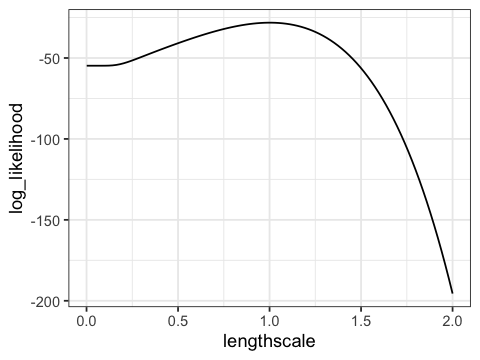

In [178]:
log_lik_df = data.frame(lengthscale = lengthscale_grid, log_likelihood = log_lik_evals)

ggplot(log_lik_df) +
    geom_line(aes(x = lengthscale, y = log_likelihood)) +
    theme_bw() 

The maximum is when $\ell \approx 1$. 

Using this value in the the posterior plot:

In [179]:
x_pred = seq(-10,10, length.out = 400) # X locations to sample

posterior_gp = gp_posterior(x_pred, x_cond, y_cond, zero_mean, matern_52_kernel, 
                            amplitude=1, lengthscale=1)

posterior_mean_vector = posterior_gp$mean_vec # mean at each x point
posterior_covariance_matrix = posterior_gp$cov_mat

posterior_variance = diag(posterior_covariance_matrix) # variances at each x point
posterior_sd = sqrt(posterior_variance) # standard deviations at each x point

Warning message in sqrt(posterior_variance):
“NaNs produced”


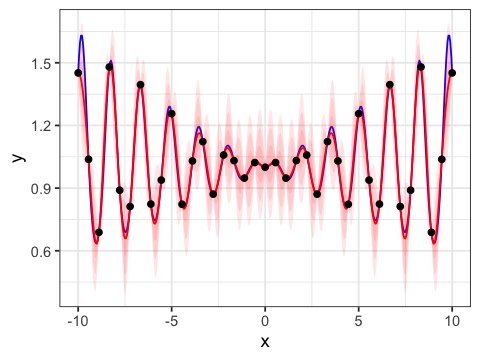

In [180]:
gp_df <- data.frame(x = x_pred, y = posterior_mean_vector,
                    y_max1 = posterior_mean_vector + 1 * posterior_sd,
                    y_min1 = posterior_mean_vector - 1 * posterior_sd,
                    y_max2 = posterior_mean_vector + 2 * posterior_sd,
                    y_min2 = posterior_mean_vector - 2 * posterior_sd,
                    y_max3 = posterior_mean_vector + 3 * posterior_sd,
                    y_min3 = posterior_mean_vector - 3 * posterior_sd)

point_df <- data.frame(x = x_cond, y = y_cond)

gp_posterior_plot <- ggplot(gp_df) +
                geom_line(data = my_func_df, aes(x = x, y = y), colour = 'blue') +
                geom_line(aes(x = x, y = y), colour = "red") +
                geom_ribbon(aes(x = x, ymin = y_min1, ymax = y_max1), alpha = 0.1,
                            fill = "red", color = "NA") +
                geom_ribbon(aes(x = x, ymin = y_min2, ymax = y_max2), alpha = 0.1,
                fill = "red", color = "NA") +
                geom_ribbon(aes(x = x, ymin = y_min3, ymax = y_max3), alpha = 0.1,
                fill = "red", color = "NA") +
                geom_point(data = point_df, aes(x = x, y = y)) +
                theme_bw()
gp_posterior_plot